<a href="https://colab.research.google.com/github/smbonilla/learningPyTorch/blob/main/03_pyTorchComputerVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Computer Vision 

## 0. Computer vision libraries 

* `torchvision` - base domain library
* `torchvision.datasets` - get datasets and data loading function for compter vision
* `torchvision.models` - get pretrained computer vision models
* `torchvision.transforms` - functions for manipulating your vision data (images) to be suitable for use with ML model 
* `torch.utils.data.Dataset` - base dataset class for PyTorch
* `torch.utils.data.DataLoader` - created a python iterable over a dataset

In [1]:
# import packages
import torch
from torch import nn 

import torchvision 
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor 

import matplotlib.pyplot as plt 

print(torchvision.__version__)


0.14.0+cu116


## 1. Getting a dataset

the dataset we will be using: FashionMNIST from `torchvision.datasets`

imagenet - an image database organized by nouns depicting millions of images

In [2]:
# Setup training data
trainData = datasets.FashionMNIST(root="data", # where to download data to?
                                   train=True, # do we want the training dataset?
                                   download=True, # do we want to download
                                   transform=ToTensor(), # how do we want to transform data
                                   target_transform=None) # how do we want to transform labels/targets

testData = datasets.FashionMNIST(root="data",
                                  train=False,
                                  download=True,
                                  transform=ToTensor(),
                                  target_transform=None)

In [3]:
# see the first bit of data

image, label = trainData[0]

classNames = trainData.classes
classNames

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [4]:
classToIDX = trainData.class_to_idx
classToIDX

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [5]:
# Check the shape of our image
print(f"Image Shape: {image.shape}") # color channel, height, width (only 1 cuz B/W)
print(f"Image Label: {classNames[label]}") 

Image Shape: torch.Size([1, 28, 28])
Image Label: Ankle boot


Image shape: torch.Size([1, 28, 28])


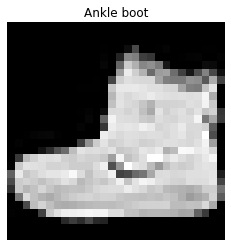

In [6]:
# visualize our data
image, label = trainData[0]

print(f"Image shape: {image.shape}")

# color channel needs to be last or gone
plt.imshow(image.squeeze(), cmap="gray");
plt.title(classNames[label]);
plt.axis(False);


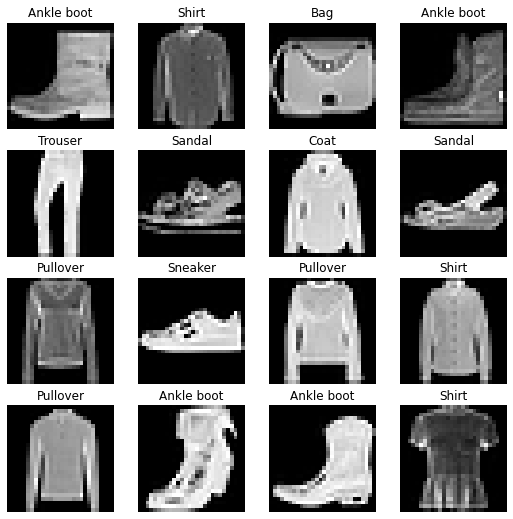

In [7]:
# plot more images
torch.manual_seed(42)

fig = plt.figure(figsize=(9,9))
rows,cols = 4,4

for i in range(1,rows*cols+1):
  
  randomIDX = torch.randint(0,len(trainData), size=[1]).item()
  
  image, label = trainData[randomIDX]

  fig.add_subplot(rows,cols,i);
  plt.imshow(image.squeeze(),cmap="gray");
  plt.title(classNames[label]);
  plt.axis(False);

In [8]:
trainData

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

## 2. Prepare DataLoader

Right now, our data is in the form of PyTorch Datasets.

DataLoader turns out dataset into a python iterable. 

We want to turn out data inot batches (or mini-batches), because:
1. It is more computationally efficient - broken down to 32 images at at time (batch size of 32)
2. It gives our neural network more chances to update its gradients per epoch (mini-batch gradient descent)



In [9]:
from torch.utils.data import DataLoader 

# Setup the batch size hyperparameter
batchSize = 32

# turn datasets into iterables (batches)
trainDataLoader = DataLoader(dataset=trainData,
                             batch_size=batchSize, 
                             shuffle=True)

testDataLoader = DataLoader(dataset=testData,
                            batch_size=batchSize,
                            shuffle=False)

In [10]:
# Check out what we created
print(f"DataLoader: {trainDataLoader, testDataLoader}")
print(f"Length of trainDataLoader: {len(trainDataLoader)} batches of {batchSize}")
print(f"Length of testDataLoader: {len(testDataLoader)} batches of {batchSize}")

DataLoader: (<torch.utils.data.dataloader.DataLoader object at 0x7f809878e250>, <torch.utils.data.dataloader.DataLoader object at 0x7f809878e100>)
Length of trainDataLoader: 1875 batches of 32
Length of testDataLoader: 313 batches of 32


In [11]:
# Check out what's inside train data loader - turn into iterable
trainFeaturesBatch, trainLabelsBatch = next(iter(trainDataLoader))
trainFeaturesBatch.shape, trainLabelsBatch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image Size: torch.Size([1, 28, 28])
Label: 6, label size: torch.Size([])


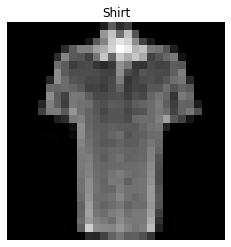

In [12]:
# Show a sample 
torch.manual_seed(42)
randomIDX = torch.randint(0,len(trainFeaturesBatch), size=[1]).item()
image,label = trainFeaturesBatch[randomIDX], trainLabelsBatch[randomIDX]
plt.imshow(image.squeeze(), cmap="gray")
plt.title(classNames[label])
plt.axis(False)
print(f"Image Size: {image.shape}")
print(f"Label: {label}, label size: {label.shape}")

## 3. Model 0: Build a baseline model

When starting to build a series of machine learning modelling experiments, it's best practice to start with a baseline model.

A baseline model is a simple model you will try and improve upon with subsequent models/experiments.

Start simply and add complexity when necessary.

In [13]:
# Create a flatten layer
flattenModel = nn.Flatten()

# Get a single sample 
x = trainFeaturesBatch[0]

# Flatten the sample
output = flattenModel(x)

# Print
print(f"Shape before flattening = {x.shape} -> [color, height, width]")
print(f"Shape after flattening = {output.shape} -> [color, height*width]")

Shape before flattening = torch.Size([1, 28, 28]) -> [color, height, width]
Shape after flattening = torch.Size([1, 784]) -> [color, height*width]


In [14]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
  def __init__(self,
               inputShape: int,
               hiddenUnits: int,
               outputShape: int):
    super().__init__()
    self.layerStack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=inputShape, 
                  out_features=hiddenUnits),
        nn.Linear(in_features=hiddenUnits,
                  out_features=outputShape)
    )

  def forward(self, x):
    return self.layerStack(x)

torch.manual_seed(42)

model0 = FashionMNISTModelV0(inputShape = 784, # this is 28*28
                             hiddenUnits = 10, # units in hidden layer 
                             outputShape = len(classNames)) # number of class names

model0.to("cpu")

model0

FashionMNISTModelV0(
  (layerStack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [15]:
dummyX = torch.rand([1,1,28,28])

model0(dummyX).shape # one logit per class

torch.Size([1, 10])

# Set up loss, optimizer, and evaluation metrix

* Loss function - since we're working with multi-class data, our loss function will be `nn.CrossEntropyLoss()`
* Optimizer - our optimizer `torch.optim.SGD()`
* Evaluation - accuracy (b/c we're working on a classification prob)

In [16]:
import requests
from pathlib import Path

# download helper functions from learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("Skipping download...")
else:
  print("downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)
  f.close()



Skipping download...


In [17]:
# Import accuracy metric
from helper_functions import accuracy_fn

# setup loss function and optimizer
lossFn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model0.parameters(),
                            lr=0.1)


### 3.2 Creating a function to time our experiments

Machine Learning is very experimental. 

Two of the main things you'll often want to track are:
1. Model's performance (loss and accruacy values etc)
2. How fast it runs

In [18]:
from timeit import default_timer as timer 

def printTrainTime(start: float,
                   end: float,
                   device: torch.device=None):
  """
  Prints difference between start and end time.
  """
  totalTime = end - start
  print(f"Train time on {device}: {totalTime:.3f} seconds")
  return totalTime 

In [19]:
startTime = timer()
# some code...
endTime = timer()
printTrainTime(start=startTime, end=endTime, device="cpu")

Train time on cpu: 0.000 seconds


3.8798000332462834e-05

### 3.3 Creating a training loop and training on batches (instead of epoch)

1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss *per batch*. 
3. Loop through testing batches, perform testing steps, calculate the test loss *per batch*.
4. Print out what's happening
5. Time it all (for fun)

In [20]:
# import tqdm for progress bar! 
from tqdm.auto import tqdm 

# set the seed and start timer 
torch.manual_seed(42)

trainTimeStartOnCpu = timer()

# set number of epochs (we'll keep this small for faster training time)
epochs = 3

# create a training & test loop 
for epoch in tqdm(range(epochs)):

  print(f"Epoch: {epoch}\n-------")

  ## Training
  trainLoss = 0 

  # add a loop to loop through training batches
  for batch, (X, y) in enumerate(trainDataLoader):
    
    # training mode
    model0.train()

    # 1. forward pass
    trainPred = model0(X)

    # 2. calculate loss (per batch)
    loss = lossFn(trainPred, y)
    trainLoss += loss # later divide by batch size

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backward
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    # print out 
    if batch % 400 == 0:
      # total number of pictures in general 
      print(f"Looked at {batch*len(X)}/{len(trainDataLoader.dataset)} samples.")

  # print out divide total train loss by length of train dataloader
  trainLoss /= len(trainDataLoader) # total number of batches inside train dataloader

  ## Testing
  testLoss, testAcc = 0,0

  model0.eval()

  with torch.inference_mode():
    for XTest,yTest in testDataLoader:

      # 1. Forward pass
      testPred = model0(XTest) # XTest is of size [batchSize, 1, 28, 28]

      # 2. Calculate the loss (accumalitvely)
      testLoss += lossFn(testPred, yTest)

      # 3. Calculate accuracy
      testAcc += accuracy_fn(y_true=yTest, y_pred=testPred.argmax(dim=1))
  
    # Calculate the test loss average per batch
    testLoss /= len(testDataLoader)

    # calculate the test acc average per batch
    testAcc /= len(testDataLoader)

  # Print out what's happening
  print(f"\nTrain Loss: {trainLoss:.4f} | Test Loss: {testLoss:.4f}, Test Acc: {testAcc:.4f}")

trainTimeEndOnCpu = timer()

totalTrainTimeModel0 = printTrainTime(start=trainTimeStartOnCpu,
                                      end=trainTimeEndOnCpu,
                                      device=str(next(model0.parameters()).device))



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train Loss: 0.5904 | Test Loss: 0.5095, Test Acc: 82.0387
Epoch: 1
-------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train Loss: 0.4763 | Test Loss: 0.4799, Test Acc: 83.1969
Epoch: 2
-------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train Loss: 0.4550 | Test Loss: 0.4766, Test Acc: 83.4265
Train time on cpu: 30.862 seconds


## 4. Make Predictions and get model 0 results



In [21]:
torch.manual_seed(42)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

def evalModel(model: torch.nn.Module,
              dataLoader: torch.utils.data.DataLoader,
              lossFn: torch.nn.Module,
              accuracyFn,
              device=device):
  """
  Returns a dictionary containing the results of model predicting on dataLoader
  """
  loss, acc = 0, 0

  model.eval()

  with torch.inference_mode():
    for X, y in tqdm(dataLoader): 
      X, y = X.to(device), y.to(device)

      # make predictions 
      yPred = model(X)

      # accumulate the loss and acc values per batch
      loss += lossFn(yPred, y) 
      acc += accuracyFn(y_true=y,
                        y_pred=yPred.argmax(dim=1))
       
    # Scale loss and acc to find average loss/acc per batch
    loss /= len(dataLoader)
    acc /= len(dataLoader)
    
  return{"modelName": model.__class__.__name__, # only works when model was created with a class
         "modelLoss": loss.item(),
         "modelAcc": acc}

# Calculate model 0 results on test dataset
model0Results = evalModel(model=model0,
                          dataLoader=testDataLoader,
                          lossFn=lossFn,
                          accuracyFn=accuracy_fn,
                          device="cpu")



  0%|          | 0/313 [00:00<?, ?it/s]

## 5. Improve model (setup device agnostic-code)

for using a GPU if there is one

In [22]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

## 6. Improve model (build a model with non-linearity)

In [23]:
# setup model 1 
class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               inputShape: int,
               hiddenUnits: int,
               outputShape: int):
    super().__init__()

    self.layerStack = nn.Sequential(
        nn.Flatten(), # flatten inputs into a single vector
        nn.Linear(in_features=inputShape,out_features=hiddenUnits), 
        nn.ReLU(),
        nn.Linear(in_features=hiddenUnits,out_features=outputShape),
        nn.ReLU()
    )

  def forward(self, x: torch.Tensor):
    return self.layerStack(x)

# Create an instance of model1 
torch.manual_seed(42)
model1 = FashionMNISTModelV1(inputShape=28*28,
                             hiddenUnits=10,
                             outputShape=len(classNames))

# Send to the GPU if available 
model1.to(device)

next(model1.parameters()).device

device(type='cuda', index=0)

In [24]:
from helper_functions import accuracy_fn 

# setup loss function and optimizer
lossFn = nn.CrossEntropyLoss() # because we are classifying between multiple classes
optimizer = torch.optim.SGD(params=model1.parameters(),
                            lr=0.1) # tries to update our model's parameters to reduce the loss

In [25]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

### Functionizing training and evaluation/testing loops

In [26]:
# MAKE A FUNCTION FOR TRAINING LOOP & TESTING LOOP

def trainStep(model: torch.nn.Module,
              trainDataLoader: torch.utils.data.DataLoader,
              lossFn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              accuracyFn,
              device: torch.device=device):
  """
  Performs a training step with model trying to learn on trainDataLoader
  """
  
  trainLoss, trainAcc = 0, 0

  # put model into training mode
  model.train()

  for batch, (X,y) in enumerate(trainDataLoader):

    # put data on target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass 
    trainPred = model(X)

    # 2. Calculate loss & accuracy
    loss = lossFn(trainPred, y)
    trainLoss += loss
    trainAcc += accuracyFn(y_true=y,y_pred=trainPred.argmax(dim=1))

    # 3. Optimizer zero grad
    optimizer.zero_grad() 

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step() 

  # calculate train loss and train accuracy per batch
  trainLoss /= len(trainDataLoader)
  trainAcc /= len(trainDataLoader)

  print(f"Train loss: {trainLoss:.5f} | Train acc: {trainAcc:.2f}%")

  return trainLoss, trainAcc


In [27]:
def testStep(model: torch.nn.Module,
            testDataLoader: torch.utils.data.DataLoader,
            lossFn: torch.nn.Module,
            accuracyFn,
            device: torch.device=device):
  """
  Performs a testing loop step on model going over testDataLoader.
  """
  testLoss, testAcc = 0, 0
  
  # put the model in evaluation mode
  model.eval()

  # turn on inference mode context manager
  with torch.inference_mode():
    
    for X, y in testDataLoader:

      # Put data on device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      testPreds = model(X)

      # 2. Compute Loss/Accuracy
      testLoss += lossFn(testPreds, y)
      testAcc += accuracyFn(y_true=y, y_pred=testPreds.argmax(dim=1))

    # compute average per batch 
    testLoss /= len(testDataLoader)
    testAcc /= len(testDataLoader)

    # print out
    print(f"Test Loss: {testLoss:.5f} | Test Accuracy: {testAcc:.2f}%")
  
  return testLoss, testAcc

In [28]:
from timeit import default_timer as timer

torch.manual_seed(42)

epochs = 3

# Measure time 
trainTimeStartOnGpu = timer()

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n--------")

  trainStep(model=model1,
            trainDataLoader=trainDataLoader,
            lossFn=lossFn,
            optimizer=optimizer,
            accuracyFn=accuracy_fn,
            device=device)
  
  testStep(model=model1,
           testDataLoader=testDataLoader,
           lossFn=lossFn,
           accuracyFn=accuracy_fn,
           device=device)

trainTimeEndOnGpu = timer()
totalTrainTimeModel1 = printTrainTime(start=trainTimeStartOnGpu,
                                      end=trainTimeEndOnGpu,
                                      device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
--------
Train loss: 1.09199 | Train acc: 61.34%
Test Loss: 0.95636 | Test Accuracy: 65.00%
Epoch: 1
--------
Train loss: 0.78101 | Train acc: 71.93%
Test Loss: 0.72227 | Test Accuracy: 73.91%
Epoch: 2
--------
Train loss: 0.67027 | Train acc: 75.94%
Test Loss: 0.68500 | Test Accuracy: 75.02%
Train time on cuda: 24.464 seconds


In [29]:
print(f"model 0 results: {model0Results}")
print(f"train time on CPU: {totalTrainTimeModel0}")

model 0 results: {'modelName': 'FashionMNISTModelV0', 'modelLoss': 0.47663894295692444, 'modelAcc': 83.42651757188499}
train time on CPU: 30.861922822999986


In [30]:
# Get model1 results dictionary
model1Results = evalModel(model=model1,
                          dataLoader=testDataLoader,
                          lossFn=lossFn,
                          accuracyFn=accuracy_fn,
                          device=device)

print(f"model 1 results: {model1Results}")
print(f"train time on GPU: {totalTrainTimeModel1}")

  0%|          | 0/313 [00:00<?, ?it/s]

model 1 results: {'modelName': 'FashionMNISTModelV1', 'modelLoss': 0.6850008964538574, 'modelAcc': 75.01996805111821}
train time on GPU: 24.46380519100012


## Model 2: Building a Convolutional Neural Network (CNN)

CNN's are known for their capabilities finding patterns in visual data.

To find out what's happening inside a CNN: https://poloclub.github.io/cnn-explainer/


In [31]:
# Create a convolutional neural network 
class FashionMNISTModelV2(nn.Module):
  """
  Model architecture that replicates the TinyVGG model from CNN explainer website.

  Two convolution blocks - called feature extractors 

  One layer - called classification layer
  """
  def __init__(self, inputShape: int, hiddenUnits: int, outputShape:int):
    super().__init__()
    self.convBlock1 = nn.Sequential(
        nn.Conv2d(in_channels=inputShape,
                  out_channels=hiddenUnits,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hiddenUnits,
                  out_channels=hiddenUnits,
                  kernel_size=3,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.convBlock2 = nn.Sequential(
        nn.Conv2d(in_channels=hiddenUnits,
                  out_channels=hiddenUnits,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hiddenUnits,
                  out_channels=hiddenUnits,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hiddenUnits*7*7, # print out size up till now to find this
                  out_features=outputShape)
    )

  def forward(self, x): 
    x = self.convBlock1(x)
    #print(f"Output shape of convBlock1: {x.shape}")
    x = self.convBlock2(x)
    #print(f"Output shape of convBlock2: {x.shape}")
    x = self.classifier(x)
    #print(f"Output shape of classifier: {x.shape}")
    return x

In [32]:
# instantiate a model
torch.manual_seed(42)

model2 = FashionMNISTModelV2(inputShape=1, # color channel - if colors this would be 3
                             hiddenUnits=10,
                             outputShape=len(classNames)).to(device)

In [33]:
# pass image through model
print(image.shape)
model2(image.to(device).unsqueeze(0))


torch.Size([1, 28, 28])


tensor([[ 0.0336, -0.0608,  0.0488, -0.0278, -0.0114,  0.0173, -0.0064, -0.0112,
          0.0315,  0.0112]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [34]:
## 7.1 stepping through nn.Convs2d()
import numpy as np 

torch.manual_seed(42)

# create a batch of images
images = torch.randn(size=(32,3,64,64))
testImage = images[0]

print(testImage.shape)

# testImage = testImage.numpy()
# testImage = np.moveaxis(testImage, 0, -1)
# testImage = torch.tensor(testImage)

# print(testImage.shape)

# # plot test image
# plt.imshow(testImage.squeeze())
# plt.title("Random Test Image")
# plt.axis(False)

torch.Size([3, 64, 64])


In [35]:
# Create a single conv2d layer
torch.manual_seed(42)

convLayer = nn.Conv2d(in_channels=3,
                      out_channels=10,
                      kernel_size=3,
                      stride=1,
                      padding=0)

convOutput = convLayer(testImage)
convOutput.shape

torch.Size([10, 62, 62])

In [36]:
## 7.1 stepping through nn.MxPool2d()
print(f"Test image original shape: {testImage.shape}")

# Create a sample 
maxPoolLayer = nn.MaxPool2d(kernel_size=2)

# pass data through just conv
testImageConv = convLayer(testImage)
print(f"Shape after convolution layer: {testImageConv.shape}")

# pass data through maxPoolLayer
testImageMaxPool = maxPoolLayer(testImageConv)
print(f"Shape after conv & max pool layers: {testImageMaxPool.shape}")


Test image original shape: torch.Size([3, 64, 64])
Shape after convolution layer: torch.Size([10, 62, 62])
Shape after conv & max pool layers: torch.Size([10, 31, 31])


### 7.3 Setup a loss function and Optimizer for `model2`

In [37]:
# Setup loss function/eval metrics/optimizer
from helper_functions import accuracy_fn

lossFn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model2.parameters(),
                            lr=0.1)

### 7.4 Training and testing `model2` using training and test function

In [38]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# measure time
from timeit import default_timer as timer
trainTimeStartModel2 = timer()

# train and test model
epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")

  trainStep(model=model2,
            trainDataLoader=trainDataLoader,
            lossFn=lossFn,
            accuracyFn=accuracy_fn,
            optimizer=optimizer,
            device=device)
  
  testStep(model=model2,
           testDataLoader=testDataLoader,
           lossFn=lossFn,
           accuracyFn=accuracy_fn,
           device=device)

trainTimeEndModel2 = timer()

totalTrainTimeModel2 = printTrainTime(start=trainTimeStartModel2,
                                        end=trainTimeEndModel2,
                                        device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Train loss: 0.59203 | Train acc: 78.48%
Test Loss: 0.39324 | Test Accuracy: 85.88%
Epoch: 1
------
Train loss: 0.36142 | Train acc: 86.99%
Test Loss: 0.35268 | Test Accuracy: 86.90%
Epoch: 2
------
Train loss: 0.32230 | Train acc: 88.27%
Test Loss: 0.33153 | Test Accuracy: 88.09%
Train time on cuda: 32.921 seconds


In [39]:
# get model2 results
model2Results = evalModel(model=model2,
                          dataLoader=testDataLoader,
                          lossFn=lossFn,
                          accuracyFn=accuracy_fn,
                          device=device)

model2Results

  0%|          | 0/313 [00:00<?, ?it/s]

{'modelName': 'FashionMNISTModelV2',
 'modelLoss': 0.3315337598323822,
 'modelAcc': 88.08905750798722}

In [40]:
model0Results

{'modelName': 'FashionMNISTModelV0',
 'modelLoss': 0.47663894295692444,
 'modelAcc': 83.42651757188499}

## 8. Compare model results and training time

In [41]:
import pandas as pd
compareResults = pd.DataFrame([model0Results,
                                model1Results,
                                model2Results])
compareResults

,modelName,modelLoss,modelAcc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.685001,75.019968
2,FashionMNISTModelV2,0.331534,88.089058


In [42]:
 # add training time to results comparison
compareResults["trainingTime"] = [totalTrainTimeModel0,
                                   totalTrainTimeModel1,
                                   totalTrainTimeModel2]

compareResults

,modelName,modelLoss,modelAcc,trainingTime
0,FashionMNISTModelV0,0.476639,83.426518,30.861923
1,FashionMNISTModelV1,0.685001,75.019968,24.463805
2,FashionMNISTModelV2,0.331534,88.089058,32.920965


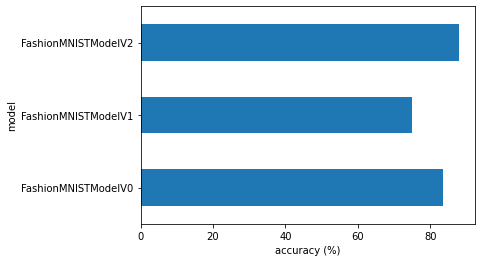

In [43]:
# Visualize our model results 
compareResults.set_index("modelName")["modelAcc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

## 9. Make and evaluate random predictions with best model 

In [44]:
def makePredictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device=device):
  predProbs = []

  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample (add a batch dim and pass to target device)
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # forward pass (model outputs raw logits)
      predLogit = model(sample)

      # prediction probability 
      predProb = torch.softmax(predLogit.squeeze(),dim=0)

      # get predProbs off the GPU for further calculations
      predProbs.append(predProb.cpu())

  # stack the predProbs to turn list into a tensor
  return torch.stack(predProbs)




In [45]:
import random
#random.seed(42)
testSamples = []
testLabels = []

for sample, label in random.sample(list(testData), k = 9):
  testSamples.append(sample)
  testLabels.append(label)

# View the first sample shape
testSamples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Trouser')

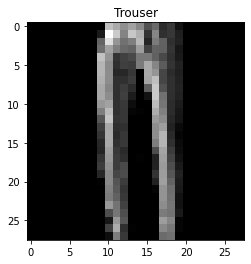

In [46]:
plt.imshow(testSamples[0].squeeze(),cmap="gray")
plt.title(classNames[testLabels[0]])

In [47]:
# Make Predictions
predProbs = makePredictions(model=model2,
                            data=testSamples)

# Convert to prediction labels 
predClasses = predProbs.argmax(dim=1)
predMax = predProbs.max(dim=1).values
predMax[1].item()

0.6856399178504944

In [48]:
# visualizing random subset of data and predictions
def plotRandomPredictions(testSamples: list,
                          testLabels: list,
                          classNames: list,
                          predClasses: torch.tensor,
                          predMax: torch.tensor):
  
  fig = plt.figure(figsize=(9,11))
  rows,cols = 3,3

  for i in range(1,rows*cols+1):

    #fig.add_subplot(rows,cols,i+1)
    fig.add_subplot(rows,cols,i);
    plt.imshow(testSamples[i-1].squeeze(),cmap="gray")
    plt.title(f"Actual Label: {classNames[testLabels[i-1]]} \n Predicted Label: {classNames[predClasses[i-1]]} \n Prediction Probability: {predMax[i-1].item()*100:.2f}")
    plt.axis(False)

  

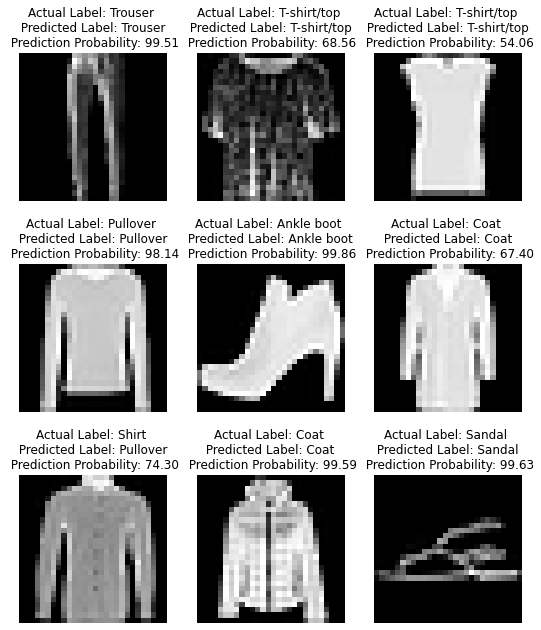

In [49]:
plotRandomPredictions(testSamples=testSamples,
                      testLabels=testLabels,
                      classNames=classNames,
                      predClasses=predClasses,
                      predMax=predMax)

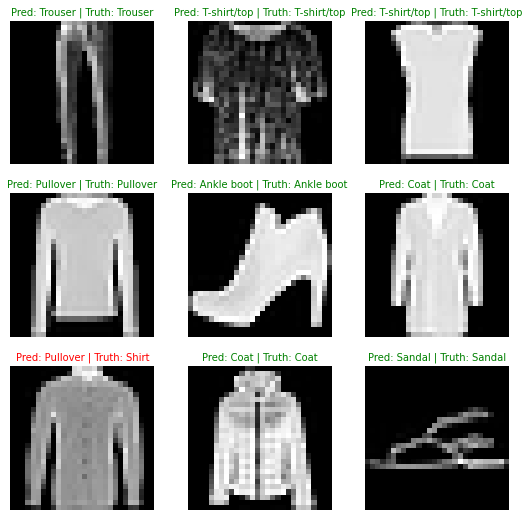

In [50]:
# Plot predictions 
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3
for i, sample in enumerate(testSamples):
  # Create subplot
  plt.subplot(nrows,ncols, i+1)

  # Plot the target image 
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction in text form
  predLabel = classNames[predClasses[i]]

  # get the truth label (in text form)
  truthLabel = classNames[testLabels[i]]

  # Create a title for the plot
  titleText = f"Pred: {predLabel} | Truth: {truthLabel}"

  # Check for equality between pred and truth and change the color of title of text
  if predLabel == truthLabel:
    plt.title(titleText,fontsize=10,c="g")
  else:
    plt.title(titleText, fontsize=10,c="r")

  plt.axis(False);

## 10. Making a confusion matrix for further prediction evaluation

A confusion matrix is a fantastic way of evaluating your classification models visually! 

1. Make predictions with our trained model on the test dataset
2. Make a confusion matrix `torchmetrics.ConfusionMatrix`
3. Plot the confusion matrix using `mlxtend.plotting.plot_confusion_martix()`

In [51]:
# Make some predictions across our entire test data set 
from tqdm.auto import tqdm 

# 1. make predictions with trained model
yPreds = []
model2.eval()
with torch.inference_mode():
  for X,y in tqdm(testDataLoader, desc="Making Predictions..."):
    # Send the data and targets to target device
    X, y = X.to(device), y.to(device)

    # do the forward pass 
    yLogit = model2(X)

    # Turn predictions from logits -> prediction probabilites -> labels
    yPred = torch.softmax(yLogit.squeeze(), dim=0).argmax(dim=1)

    # put predictions on CPU for evaluation
    yPreds.append(yPred.cpu())

# Concatenate list of predictions into a tensor
print(len(yPreds[0])) # y preds is a list 313 tensors with 32 predictions each
yPredTensor = torch.cat(yPreds) # moves all predictions from their batches to a single long list
yPredTensor.shape # yPredTensor is a tensor with 10000 predictions


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

32


torch.Size([10000])

In [52]:
# see if require packages are installed and if not, install them... how to install and upgrade in google collab
# you will have to restart your run time
try:
  import torchmetrics, mlxtend
  print(f"mlxtend: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend version should be 0.19.0 or higher"
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

mlxtend: 0.21.0


In [57]:
yPredTensor, testData.targets

(tensor([9, 2, 1,  ..., 8, 1, 8]), tensor([9, 2, 1,  ..., 8, 1, 5]))

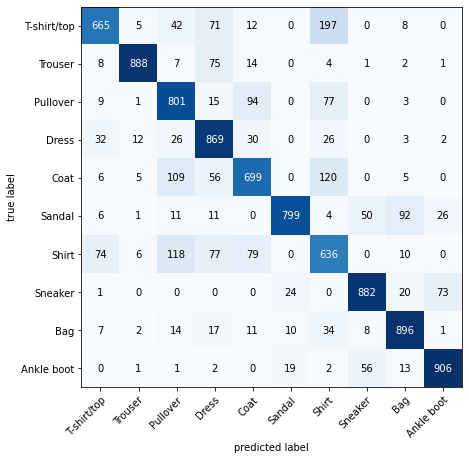

In [60]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(classNames), task="multiclass")
confmatTensor = confmat(preds=yPredTensor, target=testData.targets)

# 3. plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat = confmatTensor.numpy(), # matplotlib likes working with numpy
    class_names = classNames,
    figsize=(10,7)
)

## 11. SAVE AND RELOAD TRAINED MODEL

In [61]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "computerVisionModel2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model2.state_dict(),
           f=MODEL_SAVE_PATH)

# 4. check the saved file path
!ls -l models/computerVisionModel2.pth 

Saving model to: models/computerVisionModel2.pth
-rw-r--r-- 1 root root 34595 Dec  8 13:19 models/computerVisionModel2.pth


In [63]:
# Create a new instance of model 2 
torch.manual_seed(42)
loadedModel2 = FashionMNISTModelV2(inputShape=1,
                                   hiddenUnits=10,
                                   outputShape=len(classNames))

# Load in the save state_dict()
loadedModel2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# send the model to target device
loadedModel2.to(device)

FashionMNISTModelV2(
  (convBlock1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convBlock2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [64]:
# Evaluate the model so it is the same as model2Results
model2Results

{'modelName': 'FashionMNISTModelV2',
 'modelLoss': 0.3315337598323822,
 'modelAcc': 88.08905750798722}

In [65]:
torch.manual_seed(42)

loadedModel2Results = evalModel(
    model=loadedModel2,
    dataLoader=testDataLoader,
    lossFn=lossFn,
    accuracyFn=accuracy_fn
)

loadedModel2Results

  0%|          | 0/313 [00:00<?, ?it/s]

{'modelName': 'FashionMNISTModelV2',
 'modelLoss': 0.3315337598323822,
 'modelAcc': 88.08905750798722}

In [66]:
# Check if model results are close to eachother
torch.isclose(torch.tensor(model2Results["modelLoss"]), torch.tensor(loadedModel2Results["modelLoss"]))

tensor(True)